In [16]:
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

/home/supragyaraj/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [17]:
import os
os.chdir('data/Stocks/')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Stocks/'

In [18]:
filenames = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(x) > 0]
filenames = random.sample(filenames,10)
print(filenames)

['ardm.us.txt', 'tear.us.txt', 'star.us.txt', 'sti_e.us.txt', 'pay.us.txt', 'kura.us.txt', 'clyh.us.txt', 'kmg.us.txt', 'chma.us.txt', 'spns.us.txt']


In [19]:
def stock_graph(symbol,company_name):
    df = pd.read_csv("{}.us.txt".format(symbol))
    df[['Close']].plot()
    plt.title(company_name)
    plt.show()

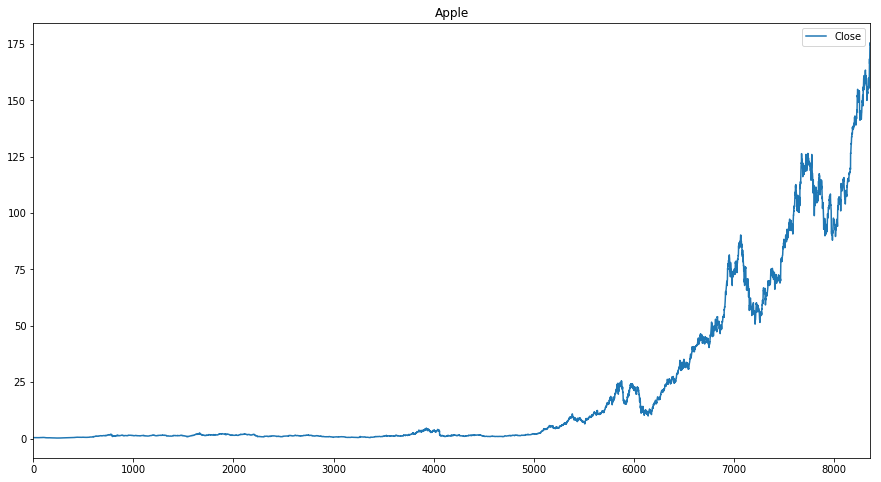

In [20]:
stock_graph("aapl","Apple")

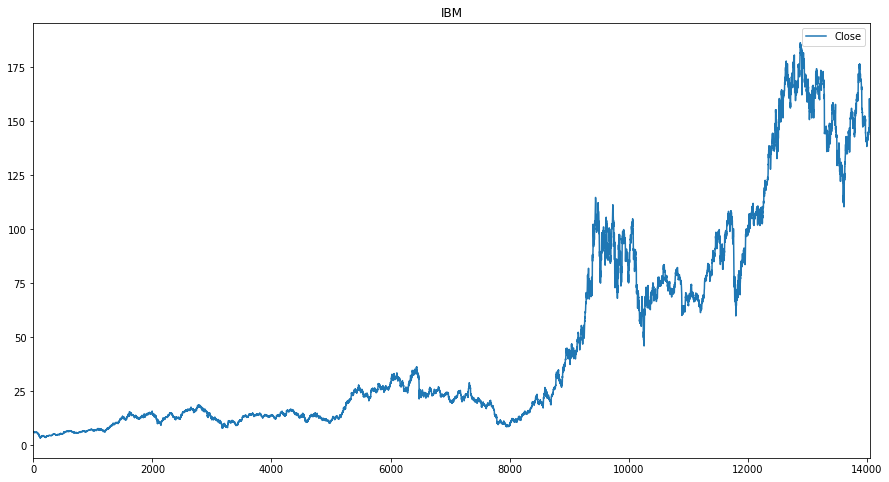

In [21]:
stock_graph("ibm","IBM")

In [22]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

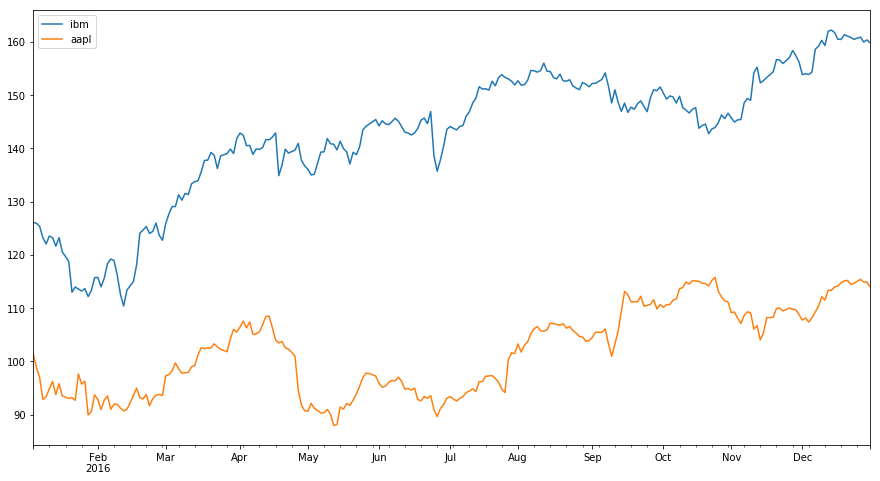

In [23]:
dates = pd.date_range('2016-01-02','2016-12-31',freq='B')
symbols = ['ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.interpolate().plot()
plt.show()

ibm     125.970
aapl     98.885
Name: 2016-01-05 00:00:00, dtype: float64


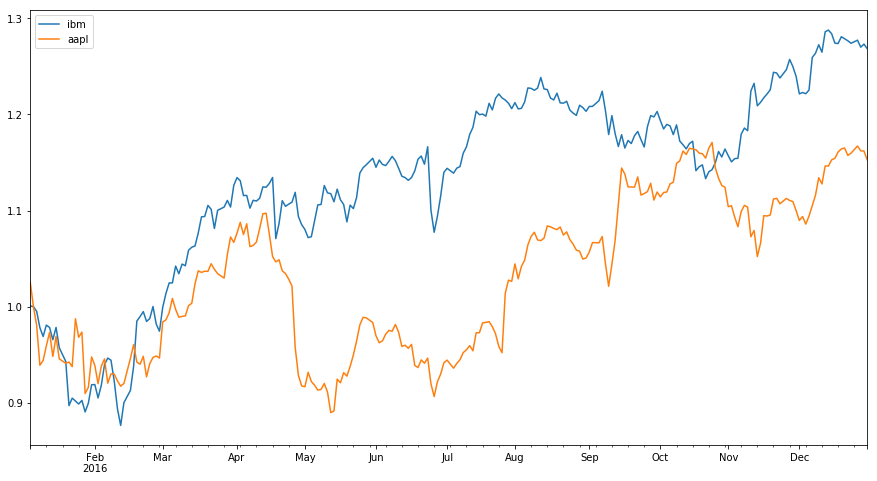

In [24]:
print(df.iloc[1,:])
df = df / df.iloc[1,:]
df.interpolate().plot()
plt.show()

In [25]:
def daily_return(df):
    dr = df.copy()
    dr = dr[:-1].values / dr[1:] - 1
    return dr

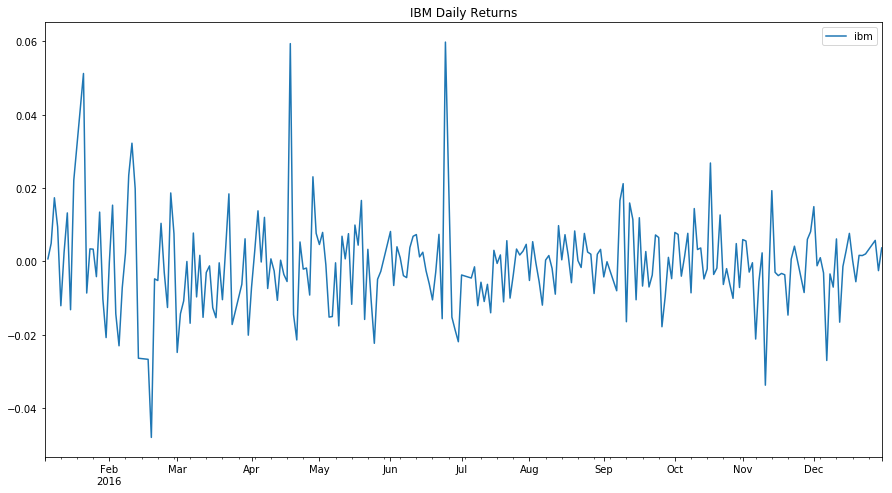

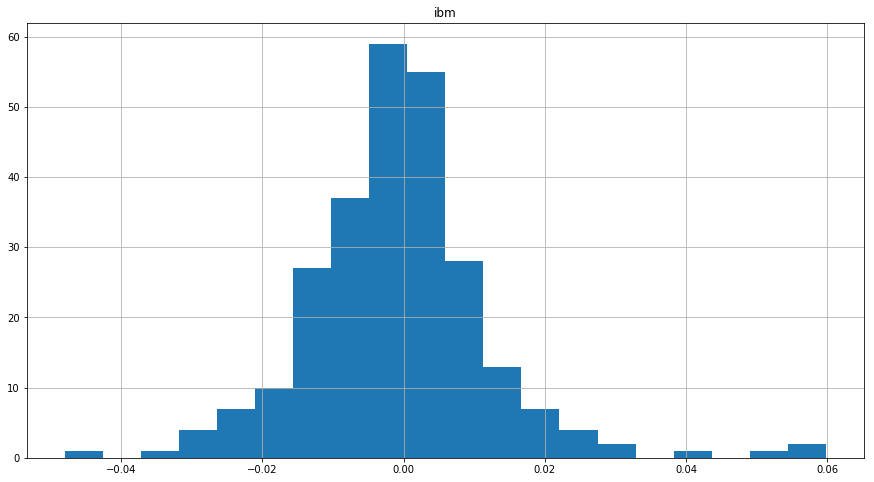

In [26]:
dates = pd.date_range('2016-01-01','2016-12-31',freq='B')
symbols = ['ibm']
df = stocks_data(symbols, dates)
dr = daily_return(df)
dr = dr.interpolate()
dr.interpolate().plot()
plt.title('IBM Daily Returns')
plt.show()
dr.hist(bins=20)
plt.show()

In [27]:
def cum_return(df):
    dr = df.copy()
    dr.cumsum()
    return dr

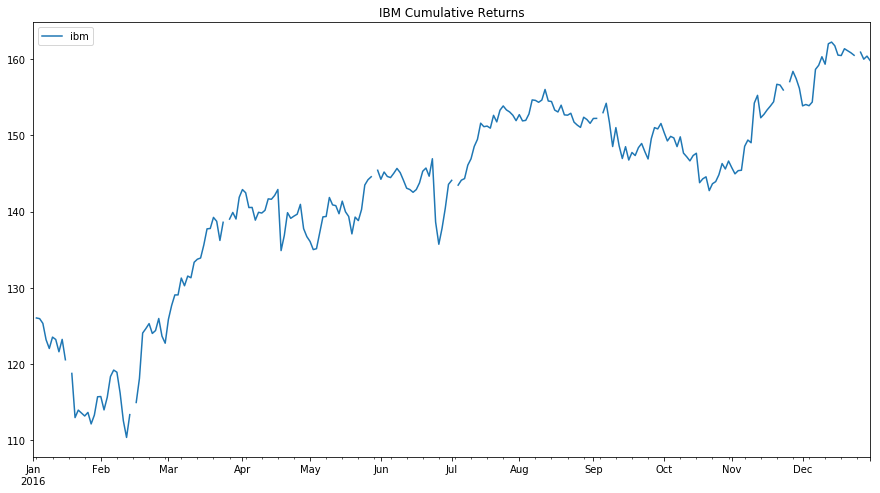

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2b0079dd8>]], dtype=object)

In [41]:
dates = pd.date_range('2016-01-01','2016-12-31',freq='B')
symbols = ['ibm']
df = stocks_data(symbols, dates)
dr = cum_return(df)
dr.plot()
plt.title('IBM Cumulative Returns')
plt.show()
dr.hist()

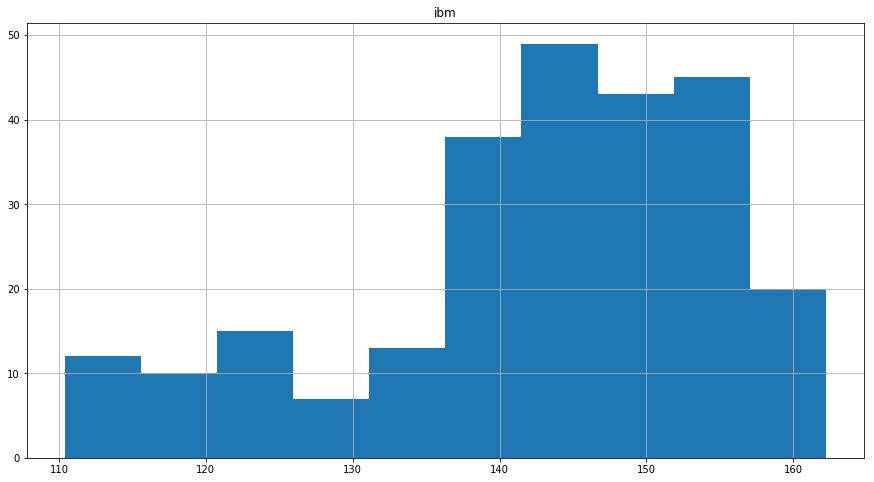

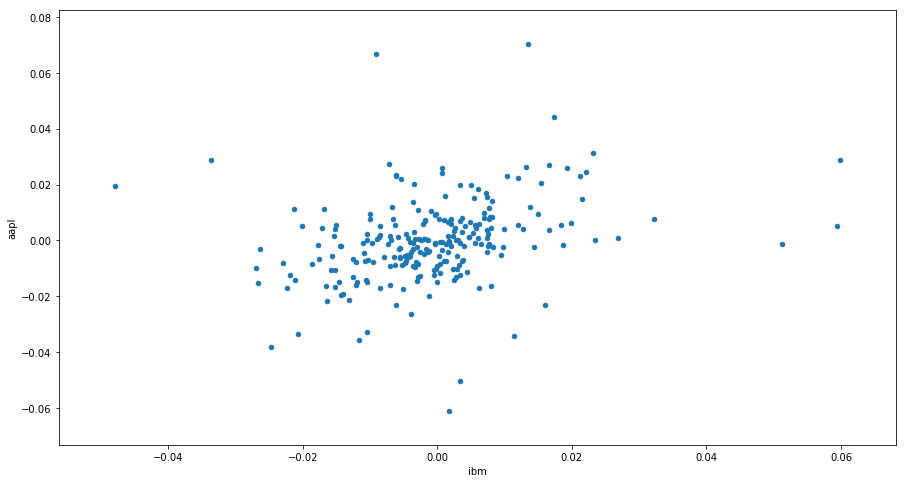

In [29]:
dates = pd.date_range('2016-01-01','2016-12-31',freq='B')
symbols = ['ibm','aapl']
df = stocks_data(symbols, dates)
dr = daily_return(df)
dr.plot(kind='scatter',x='ibm', y='aapl')
plt.show()

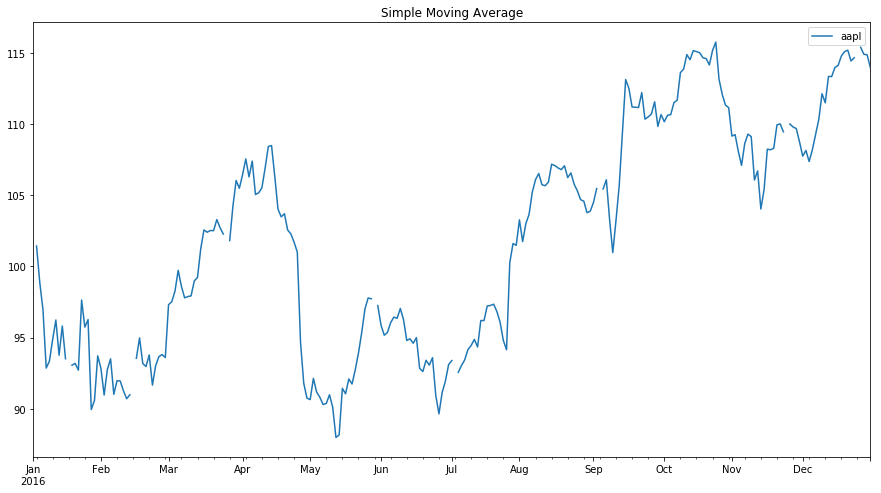

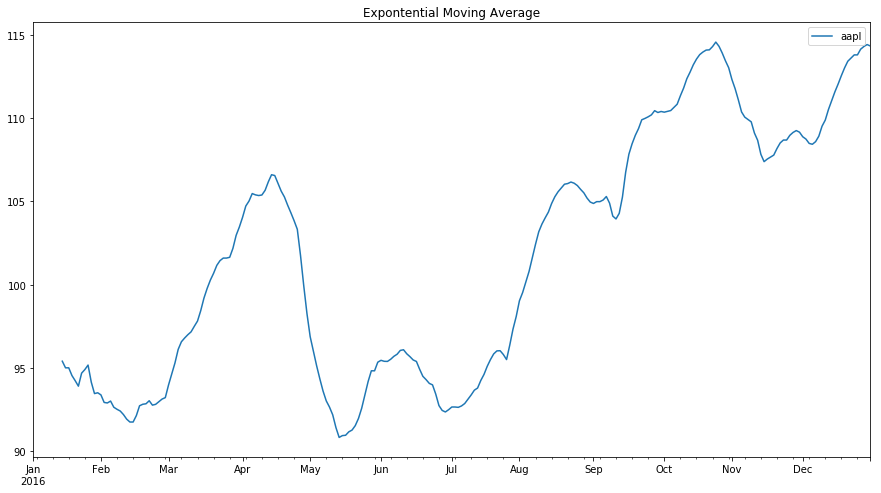

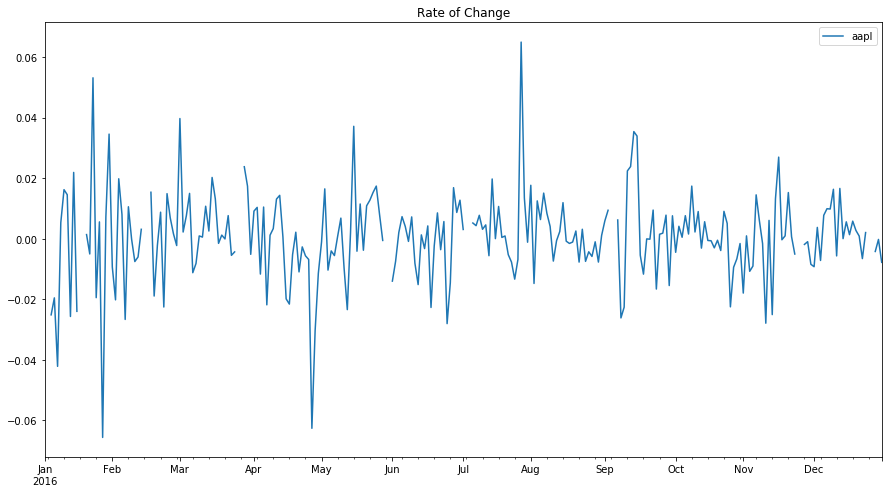

In [30]:
# Simple Moving Average
def get_SMA(df, ndays):
    dm = df.copy()
    dm.rolling(ndays).mean()
    return dm

# Expontential Moving Average
def get_EMA(df, ndays):
    dm = df.ewm( span = ndays, min_periods = ndays - 1).mean()
    return dm

# Rate of Change
def get_ROC(df, ndays):
    dn = df.diff(ndays)
    dd = df.shift(ndays)
    dr = dn/dd
    return dr

dates = pd.date_range('2016-01-01','2016-12-31',freq='B')
symbols = ['aapl']
df = stocks_data(symbols, dates)
dm = get_SMA(df, 10)
dm.plot()
plt.title('Simple Moving Average')
plt.show()
dm = get_EMA(df, 10)
dm.plot()
plt.title('Expontential Moving Average')
plt.show()

dr = get_ROC(df, 1)
dr.plot()
plt.title('Rate of Change')
plt.show()

In [32]:
filenames = ['prk.us.txt', 'bgr.us.txt', 'jci.us.txt', 'aa.us.txt', 'fr.us.txt', 'star.us.txt', 'sons.us.txt', 'ipl_d.us.txt', 'sna.us.txt', 'utg.us.txt']
filenames = [filenames[1]]
print(filenames)

data = []
for filename in filenames:
    df = pd.read_csv(filename, sep=',')

    label, _, _ = filename.split(sep='.')
    df['Label'] = filename
    df['Date'] = pd.to_datetime(df['Date'])
    data.append(df)

['bgr.us.txt']


In [33]:
r = lambda: random.randint(0,255)
traces = []

for df in data:
    clr = str(r()) + str(r()) + str(r())
#     df = df.sample(n=100, replace=True)
    df = df.sort_values('Date')
#     print(df['Label'])
    label = df['Label'].iloc[0]

    trace = plotly.graph_objs.Scattergl(
        x=df['Date'],
        y=df['Close'],
        mode='line',
        line=dict(
            color = clr
        )
    )
    traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot',
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')


In [34]:
df = data[0]
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data[0]["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [36]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [37]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 124s - loss: 0.0191
Epoch 2/5
 - 134s - loss: 0.0148
Epoch 3/5
 - 125s - loss: 0.0138
Epoch 4/5
 - 177s - loss: 0.0134
Epoch 5/5
 - 240s - loss: 0.0134


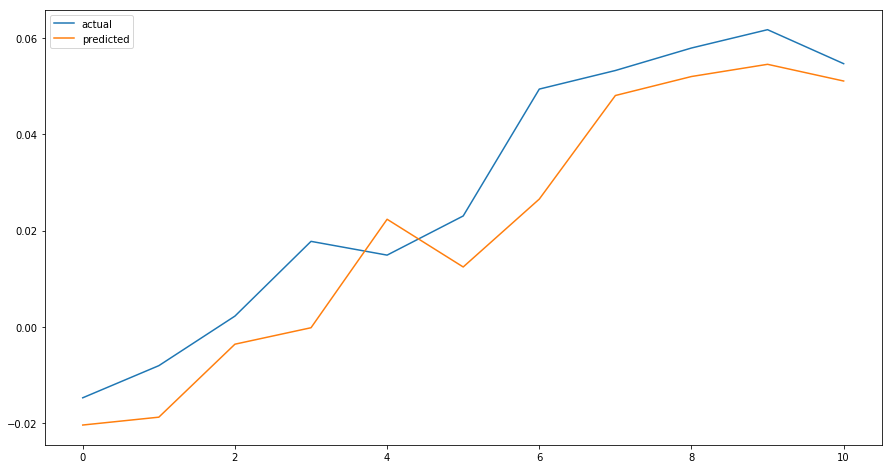

The Mean Absolute Error is: 0.009363476063299873


In [38]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

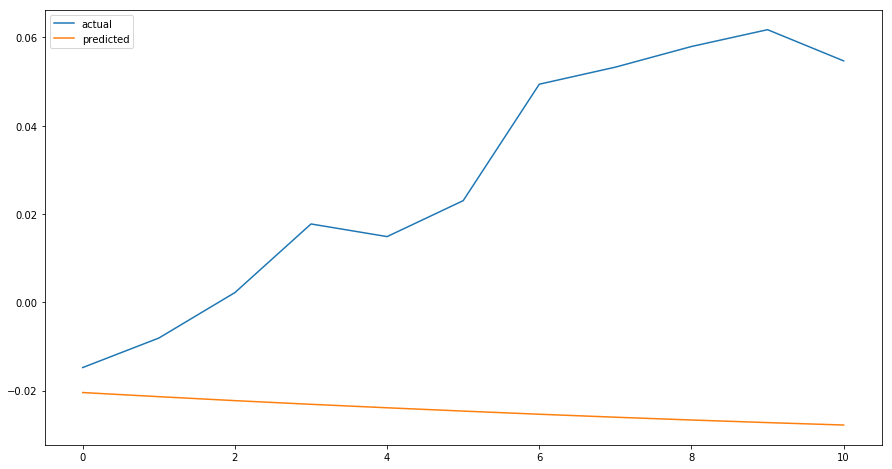

The Mean Absolute Error is: 0.05278954052806211


In [40]:
def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))